In [1]:

#Things That can be neeed to change for trainig purpose ?
# Collate Function

import os
import pickle
import yaml
import argparse

import torch
from torch.utils import data
import numpy as np
from scipy.spatial import Delaunay
from tqdm import tqdm

from model.build_model import build_gcn, build_netvlad, build_seqnet, build_airobj

from datasets.mp3d_airloc.mp3d import mp3d
from datasets.utils.batch_collator import eval_custom_collate

dataset = mp3d(base_dir="/home/aryan/Mp3d_dataset/x_view",datasets= ["mp3d"])

loader = data.DataLoader(dataset=dataset, batch_size=1, collate_fn=eval_custom_collate,shuffle=False)
batch = next(iter(loader))

Dataset Name =  mp3d
Scene Name =  qoiz87JEwZ2
Room Name =  room3
Room Name =  room4
Room Name =  lobby2
Room Name =  room1
Room Name =  lobby1
Room Name =  room2
Room Name =  kitchen
Room Name =  bathroom1
Room Name =  dining_room


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ann_masks, points, roomnames = batch[0], batch[1], batch[2]

batch_objects = []
for i in range(len(ann_masks)): # Batch Size
    keypoints = points[i]['points']
    descriptors = points[i]['point_descs']

    
    image_objects = {}
    image_objects['points'] = []
    image_objects['descs'] = []
    image_objects['ids'] = [] 

    for a in range(len(ann_masks[i])):
        ann_mask = ann_masks[i][a]['mask']
        object_filter = ann_mask[keypoints[:,0].T,keypoints[:,1].T]

        np_obj_pts = keypoints[np.where(object_filter==1)[0]].numpy()

        obj_id = str(ann_masks[i][a]['id']) 
        
        image_objects['points'].append(keypoints[np.where(object_filter==1)[0]].float().to(device))
        image_objects['descs'].append(descriptors[np.where(object_filter==1)[0]].float().to(device))
        image_objects['ids'].append(obj_id)
    
    batch_objects.append(image_objects)

In [61]:
configs = "config/eval_Airloc.yaml"
f = open(configs, 'r', encoding='utf-8')
configs = f.read()
configs = yaml.safe_load(configs)
configs['use_gpu'] = 1
configs['num_gpu'] = [0]
configs['public_model'] = 0

netvlad_model = build_netvlad(configs)
netvlad_model.eval()

Finish cuda loading
load model from ../models/netvlad_model.pth


DataParallel(
  (module): NetVLADDescriptor(
    (netvlad): NetVLAD(
      (conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

In [59]:
batch_decs = []
for image in batch_objects:
    new_image_desc = []
    for i in image['descs']:
        if i.shape[0]>5:
            new_image_desc.append(i)
    batch_decs.append(new_image_desc)

In [62]:
iter_obj_descs = netvlad_model(batch_decs[0])

In [64]:
iter_obj_descs.shape

torch.Size([7, 8192])

## Test SuperPoint Object Decriptor


In [43]:
import os
import cv2
import copy
import torch
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

# Image taken after looking at the imags from whivh the points are  taken.
img_path = '/home/aryan/Mp3d_dataset/x_view/mp3d/qoiz87JEwZ2/rooms/room3/raw_data/0_rgb.png'

src = [cv2.imread(img_path)]

In [51]:
batch_pts = []
batch_ids = []
for image in batch_objects:
    batch_pts.append(image['points'])
    batch_ids.append(image['ids'])
    
images_pts  = batch_pts[0]

In [44]:
def overlay_points(images, points_output, color=(255,0,0)):
  new_images = []
  for image, points_o in zip(images, points_output):
    image1 = image.copy()
    points = points_o.cpu().numpy()
    if len(points) == 0:
      print("no points")
    for i in range(len(points)):
      x = points[i][1].astype(int)
      y = points[i][0].astype(int)
      if x < 0:
        continue
      cv2.circle(image1, (x,y), 10, color, thickness=-1)
    new_images.append(image1)
  return new_images

no points
ID =  0


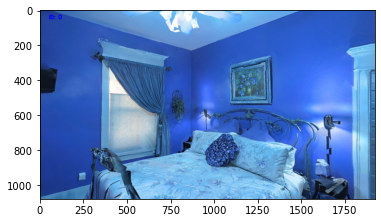

no points
ID =  183


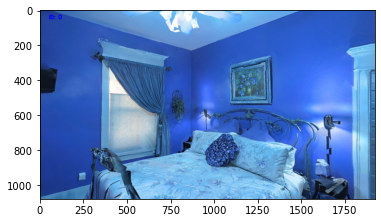

no points
ID =  189


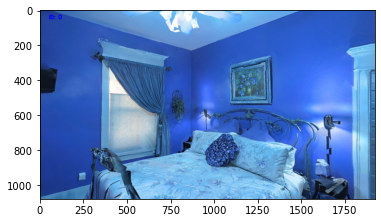

no points
ID =  331


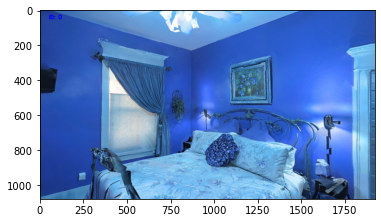

no points
ID =  346


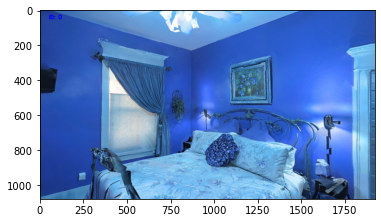

ID =  444


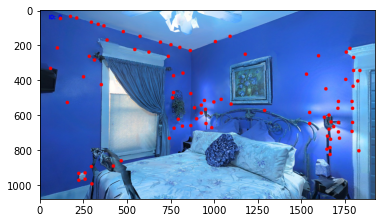

ID =  446


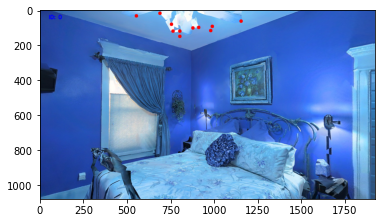

ID =  447


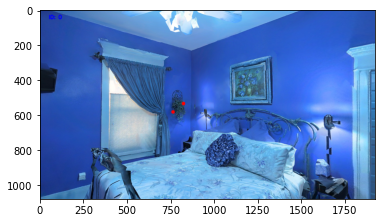

ID =  448


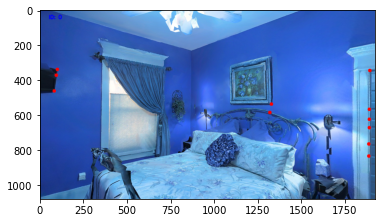

ID =  449


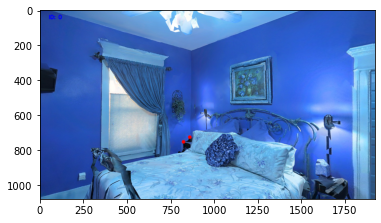

ID =  451


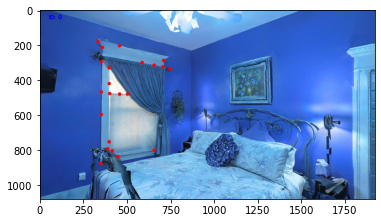

ID =  453


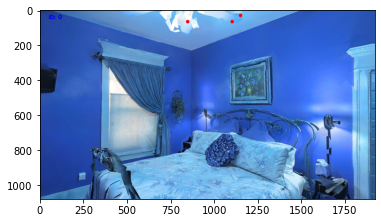

ID =  455


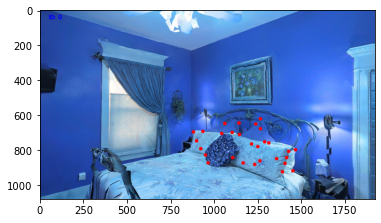

ID =  456


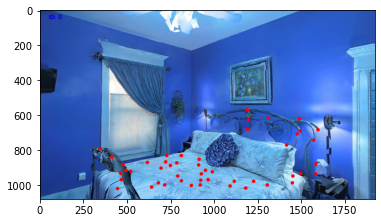

no points
ID =  458


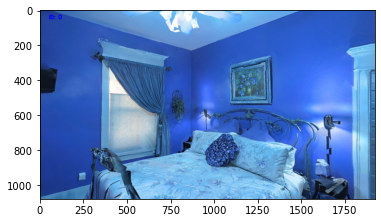

ID =  459


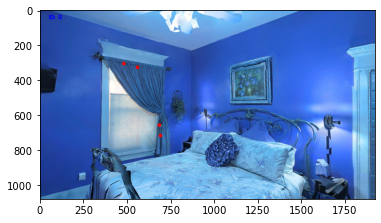

ID =  463


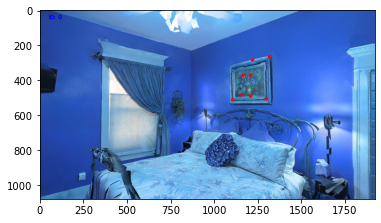

ID =  465


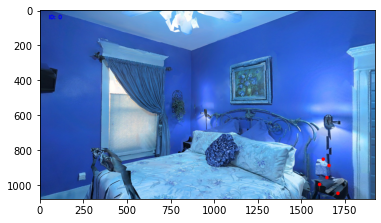

no points
ID =  469


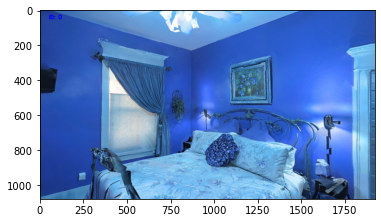

no points
ID =  473


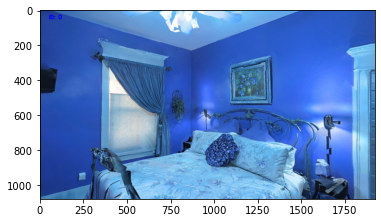

no points
ID =  477


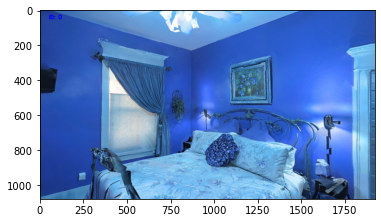

no points
ID =  490


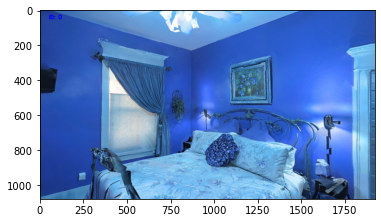

ID =  491


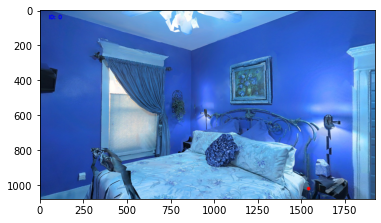

ID =  496


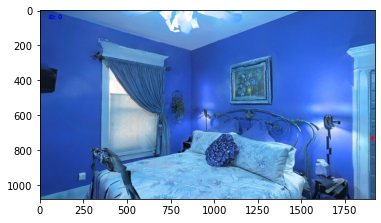

no points
ID =  502


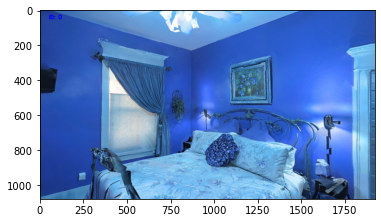

In [58]:
images = []
for i, pt in enumerate(images_pts):
    img = overlay_points(src,[pt])
    print("ID = ",batch_ids[0][i] )
    fig = plt.figure(i)
    plt.imshow(img[0])
    plt.show()
    images.append(img)